In [114]:
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

sys.path.append('../../')

In [115]:
import yaml
from pathlib import Path
from typing import Union
from functools import reduce

def save_yaml_from_csvs(directory_path: Union[str, Path], replace_in_filename: dict[str, str] = None) -> Path:
    directory = Path(directory_path)
    yaml_data = []
    
    for file in directory.glob('*.xlsx'):
        df = pd.read_excel(file)
        entry = {
            'file': reduce(lambda fn, kv: fn.replace(*kv), replace_in_filename.items(), file.name),
            'timestamp_missed_fish': [],
            'fish_track_IDs': df[df['classification'] == 'fish']['id'].tolist(),
        }
        yaml_data.append(entry)
    
    yaml_file_path = directory / "fish_labels.yaml"
    
    with open(yaml_file_path, 'w') as file:
        yaml.dump(yaml_data, file, default_flow_style=False)
    
    return yaml_file_path

directory_path = "../../data/labels/Tourelle/"
output_yaml_path = save_yaml_from_csvs(directory_path, replace_in_filename={"_YP_completed": "", ".xlsx": ".csv"})
print(f"YAML file saved at: {output_yaml_path}")


YAML file saved at: ../../data/labels/Tourelle/fish_labels.yaml


In [116]:
%load_ext autoreload
%autoreload 2
from analysis.classification_utils.features import FeatureGenerator, TrackClassifier, TrackPlotter

measurement_csv_paths = ["../../data/model_output/Tourelle_Mar11_07-10-01.csv"]

gen = FeatureGenerator(
    gt_fish_id_yaml="../../data/labels/Tourelle/fish_labels.yaml",
    measurements_csv_dir="../../data/model_output/",
    test_csv_paths=measurement_csv_paths,
    min_track_length=20, 
    force_feature_recalc=True,
    force_test_feature_recalc=True,
    min_overlapping_ratio=0.5,
    load_old_measurements=False,
    load_old_test_files=False,
    rake_mask_path="../demo/masks/stroppel_rake_front_mask.png",
    flow_area_mask_path="../demo/masks/sonar_controls.png",
    trajectory_min_overlap_ratio=0.15,
)
gen.calc_feature_dfs()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Calculating/reading features


100%|██████████| 5/5 [00:00<00:00, 10.38it/s]


Calculating/reading features


100%|██████████| 1/1 [00:00<00:00, 28.88it/s]
/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Calculating features for test data
Calculating features for train data


/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWar

# Get an Idea of Trajectory and Ground Truth

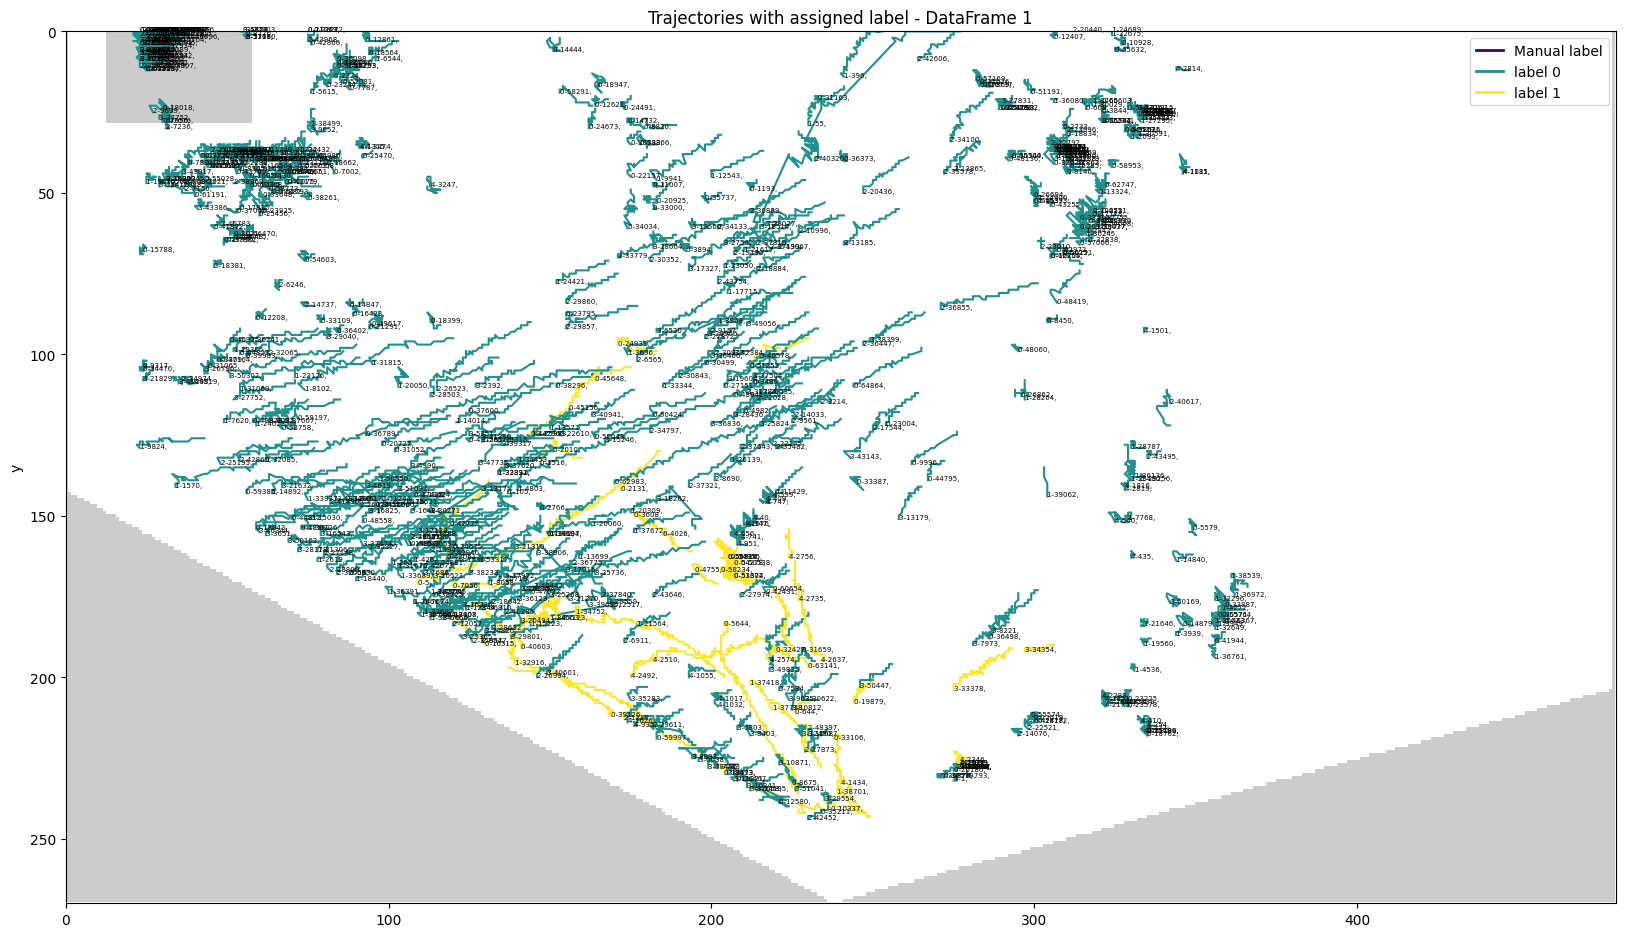

In [117]:
from copy import deepcopy

from analysis.classification_utils.features import TrackPlotter

test_plotter = TrackPlotter(deepcopy(gen.test_dfs), gen.masks)
plotter = TrackPlotter(deepcopy(gen.measurements_dfs), gen.masks)

plotter.plot_track_pairings(
    show_track_id=True,
    mask_to_show="flow_area_mask",
    column_with_label="gt_label",
    figsize=(20, 20),
)

In [118]:
# import pandas as pd
# import numpy as np

# def remove_jumps(df: pd.DataFrame, threshold: int = 10):
#     df = df.copy(deep=True)
    
#     def process_group(group):
#         # Calculate the Euclidean distance between consecutive points within the group
#         group['dist'] = np.sqrt(group['x'].diff()**2 + group['y'].diff()**2)
        
#         # Find the indices where the distance is greater than the threshold
#         jump_indices = group.index[group['dist'] > threshold].tolist()
        
#         # Add the start and end indices of the group
#         jump_indices = [group.index[0]] + jump_indices + [group.index[-1]]
        
#         # Split the group into segments at the jump indices
#         segments = []
#         for idx in range(len(jump_indices)-1):
#             prior_idx = int(idx != len(jump_indices)-2)
#             segments.append(group.loc[jump_indices[idx]:(jump_indices[idx+1]-prior_idx)])
            
#         # Find the longest segment
#         longest_segment = max(segments, key=len)
        
#         return longest_segment
    
#     # Apply the process_group function to each group
#     df = df.groupby('id').apply(process_group).reset_index(drop=True)
    
#     return df

# # Apply the function to each DataFrame in mmts_dfs
# mmts_dfs = [remove_jumps(df) for df in mmts_dfs]

# plotter = TrackPlotter(mmts_dfs, gen.masks)
# plotter.plot_track_pairings(
#     show_track_id=True,
#     mask_to_show="flow_area_mask",
#     column_with_label="gt_label",
#     figsize=(20, 20),
# )

# Identify River Velocity from Floating Debris Cluster

In [119]:
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans
# import pandas as pd

# def calculate_velocities(mmts_dfs):
#     velocities = []

#     for df in mmts_dfs:
#         unique_ids = df['id'].unique()
#         for uid in unique_ids:
#             sample = df[df.id == uid]
#             if len(sample) > 1:  # Ensure there are at least two points to calculate velocity
#                 dx = sample.x.iloc[-1] - sample.x.iloc[0]
#                 dy = sample.y.iloc[-1] - sample.y.iloc[0]
#                 dt = sample.frame.iloc[-1] - sample.frame.iloc[0]
#                 vx = dx / dt
#                 vy = dy / dt
#                 gt_label = sample.gt_label.iloc[0]  # Assuming gt_label is the same for all points of the same id
#                 velocities.append((uid, vx, vy, gt_label))
    
#     return pd.DataFrame(velocities, columns=['id', 'vx', 'vy', 'gt_label'])

# # Assuming mmts_dfs is already defined
# velocities_df = calculate_velocities(plotter.measurements_dfs)

# # Perform KMeans clustering
# kmeans = KMeans(n_clusters=2, random_state=0)  # You can change the number of clusters
# velocities_df['cluster'] = kmeans.fit_predict(velocities_df[['vx', 'vy']])

# # Plotting clustered velocities
# plt.figure(figsize=(10, 6))
# scatter = plt.scatter(velocities_df['vx'], velocities_df['vy'], c=velocities_df['cluster'], cmap='viridis', alpha=0.5)
# plt.title('Clustered Velocity Components (vx vs vy)')
# plt.xlabel('vx')
# plt.ylabel('vy')
# plt.grid(True)
# plt.legend(*scatter.legend_elements(), title="Clusters")
# plt.show()

# # Get cluster centers
# cluster_centers = kmeans.cluster_centers_
# print("Cluster Centers:\n", cluster_centers)

# # Plotting velocities colored by gt_label
# plt.figure(figsize=(10, 6))
# scatter = plt.scatter(velocities_df['vx'], velocities_df['vy'], c=velocities_df['gt_label'], cmap='viridis', alpha=0.5)
# plt.title('Velocity Components (vx vs vy) Colored by gt_label')
# plt.xlabel('vx')
# plt.ylabel('vy')
# plt.grid(True)
# plt.legend(*scatter.legend_elements(), title="gt_label")
# plt.show()

# Find the Best Model and Features

### Find the Best Feature Selection with a Greedy Algorithm

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.feature_selection import SequentialFeatureSelector

from analysis.classification_utils.classifier_evaluation import ProbaLogisticRegression, ProbaXGBClassifier, train_and_evaluate_model, predict
        

random_state = 3
feature_df = pd.concat(deepcopy(plotter.measurements_dfs)).groupby('id').first().select_dtypes(include=[np.number])
imbalance = feature_df['gt_label'].value_counts()[0] / sum(feature_df['gt_label'].value_counts())
features_to_explore = [
    'contour_area',
    'stddev_of_intensity',
    'v_smoothed_avg', 'v_smoothed_std', 'v_50th_percentile',
    'v_90th_percentile', 'v_95th_percentile',
    'traversed_distance',
    'average_smoothed_curvature_15',
    'median_smoothed_curvature_15',
    'average_bbox_size', 'average_distance_from_start',
    'average_contour_area',
    'average_pixel_intensity',
    'average_distance_from_start/traversed_distance',
]

# current best: ['traversed_distance', 'v_95th_percentile', 'average_pixel_intensity', 'average_distance_from_start', 'v_smoothed_avg']
sfs = SequentialFeatureSelector(
    # ProbaLogisticRegression(proba_threshold=0.8, class_weight='balanced'),
    ProbaXGBClassifier(proba_threshold=0.1, random_state=random_state, scale_pos_weight=imbalance, verbosity=0),
    n_features_to_select=6,
    scoring=make_scorer(fbeta_score, beta=2),
    cv=5,
    n_jobs=-1,
)
sfs.fit(feature_df[features_to_explore], feature_df['gt_label'])
# optim_features = features_to_explore[sfs.get_support()]
# print(f"Selected features: {optim_features}")
# print(f"Performance metric ({target_metric}): {optim_metric}")

6487.67s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
6487.85s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/debugpy/_vendored/force_pydevd.py:18: UserWarning: incompatible copy of pydevd already imported:
 /home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/pydevd_plugins/extensions/pydevd_plugin_omegaconf.py
  warnings.warn(msg + ':\n {}'.format('\n  '.join(_unvendored)))
/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/debugpy/_vendored/force_pydevd.py:18: UserWarning: incompatible copy of pydevd already imported:
 /home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/pydevd_plugins/extensions/pydevd_plugin_omegaconf.py
  warnings.warn(msg + ':\n {}'.format('\n  '.join(_unvendored)))
64

SequentialFeatureSelector(estimator=ProbaXGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_type=None,
                                                       interaction_constraints=None,
                                                       learni...,
                                                       max_bin=None,
                                                       max_cat_threshold=None,
                                                       max_cat_to_onehot=None,
                                                       max_delta_step=None,
                                                       max_depth=None,
                                                       max_leaves=None,
                                                       min_child_weight=None,
                                                       missing=nan,
                                                       monotone_constraints=None,
                                                       multi_strategy=None,
                                                       n_estimators=None,
                                                       n_jobs=None,
                                                       num_parallel_tree=None,
                                                       objective='binary:logistic', ...),
                          n_features_to_select=6, n_jobs=-1,
                          scoring=make_scorer(fbeta_score, beta=2))

In [121]:
optim_features = [features_to_explore[i] for i in range(len(features_to_explore)) if sfs.get_support()[i]]
optim_features

['stddev_of_intensity',
 'v_smoothed_avg',
 'v_90th_percentile',
 'v_95th_percentile',
 'average_bbox_size',
 'average_distance_from_start']

### Exact Performance of Best Model and Features

In [122]:
features_to_use = ['v_50th_percentile', 'average_distance_from_start', 'v_95th_percentile', 'contour_area', 'average_distance_from_start/traversed_distance']
metrics, y_pred, trained_classifier, trained_scaler = train_and_evaluate_model(
    feature_df,
    # ProbaLogisticRegression(proba_threshold=0.7, class_weight='balanced'),
    ProbaXGBClassifier(proba_threshold=0.1, random_state=random_state, scale_pos_weight=imbalance, verbosity=0),
    # ProbaClassifier(LogisticRegression, proba_threshold=0.7, base_estimator_kwargs={"class_weight": "balanced"}),
    # ProbaClassifier(XGBClassifier, base_estimator_kwargs={"scale_pos_weight": imbalance}, proba_threshold=0.1),
    metrics_to_show=['Accuracy', 'Precision', 'Recall', 'F1_score', 'F2_score'],
    features=features_to_use,
)

{'Accuracy': 0.9132530120481928, 'Precision': 0.44871794871794873, 'Recall': 0.546875, 'F1_score': 0.4929577464788733, 'F2_score': 0.5239520958083832} ['v_50th_percentile', 'average_distance_from_start', 'v_95th_percentile', 'contour_area', 'average_distance_from_start/traversed_distance']


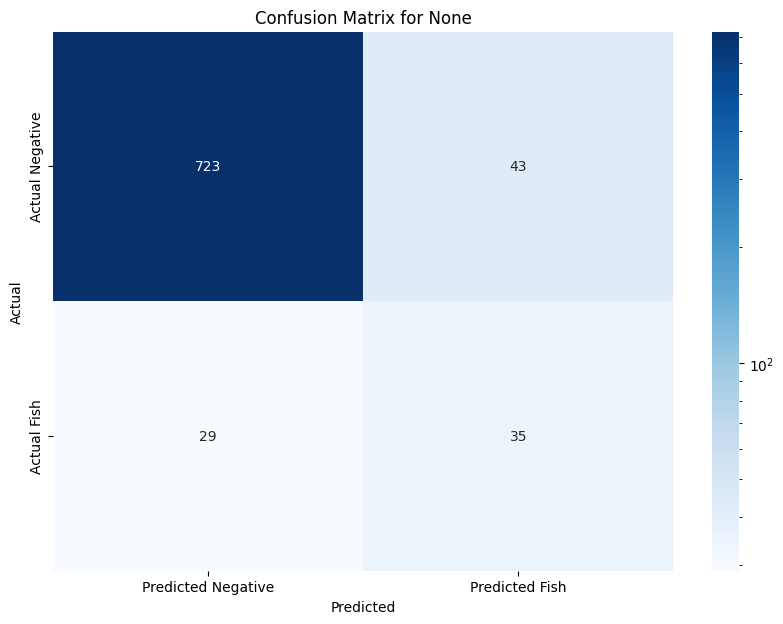

In [139]:
from analysis.classification_utils.metrics import get_confusion_matrix


y = feature_df['gt_label']
get_confusion_matrix(y, y_pred, None, plot=True)

In [137]:
# TODO: make one script with all steps for feature calc and prediction on test data
# TODO: config file for classification
# TODO: pipeline component for the prior two
# TODO: test pipeline component

In [148]:
test_feature_df = pd.concat(deepcopy(test_plotter.measurements_dfs)).groupby('id').first().select_dtypes(include=[np.number])


y_test, y_test_proba = predict(
    test_feature_df,
    trained_classifier,
    trained_scaler,
    features_to_use,
)
data = {
    'classification_v2': y_test,
    'xgboost_proba': y_test_proba[:, 1],
}
df = pd.DataFrame(data, index=test_feature_df.index)
test_plotter.overwrite_classification_v2(df)



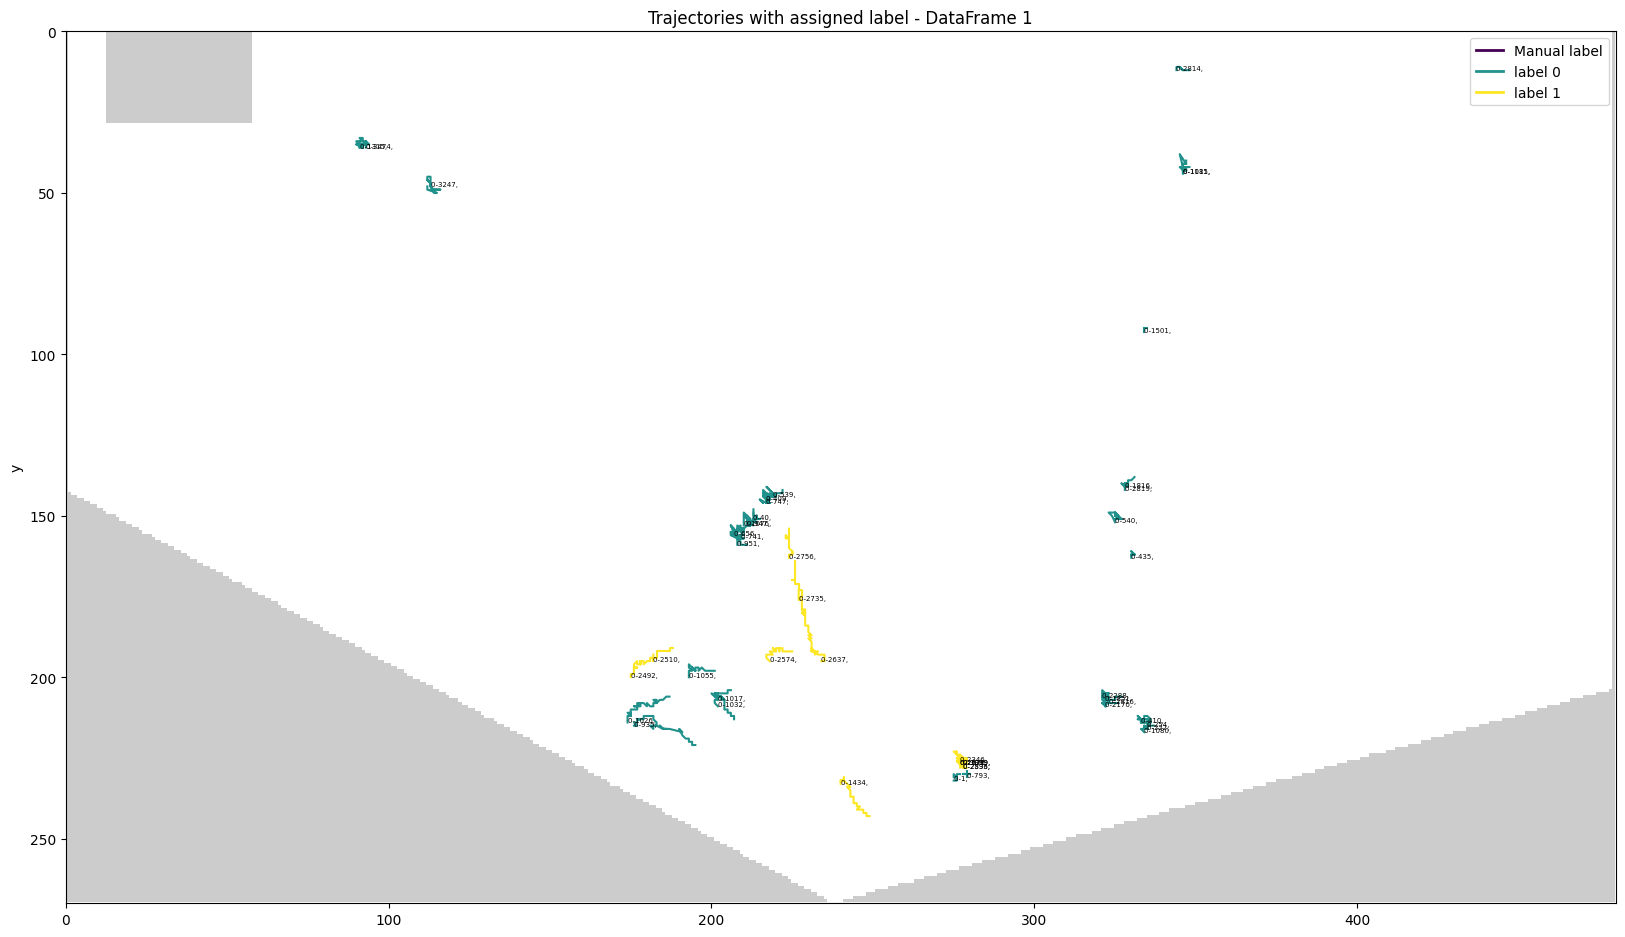

In [125]:
test_plotter.plot_track_pairings(
    show_track_id=True,
    mask_to_show="flow_area_mask",
    column_with_label="xgboost",
    figsize=(20, 20),
)

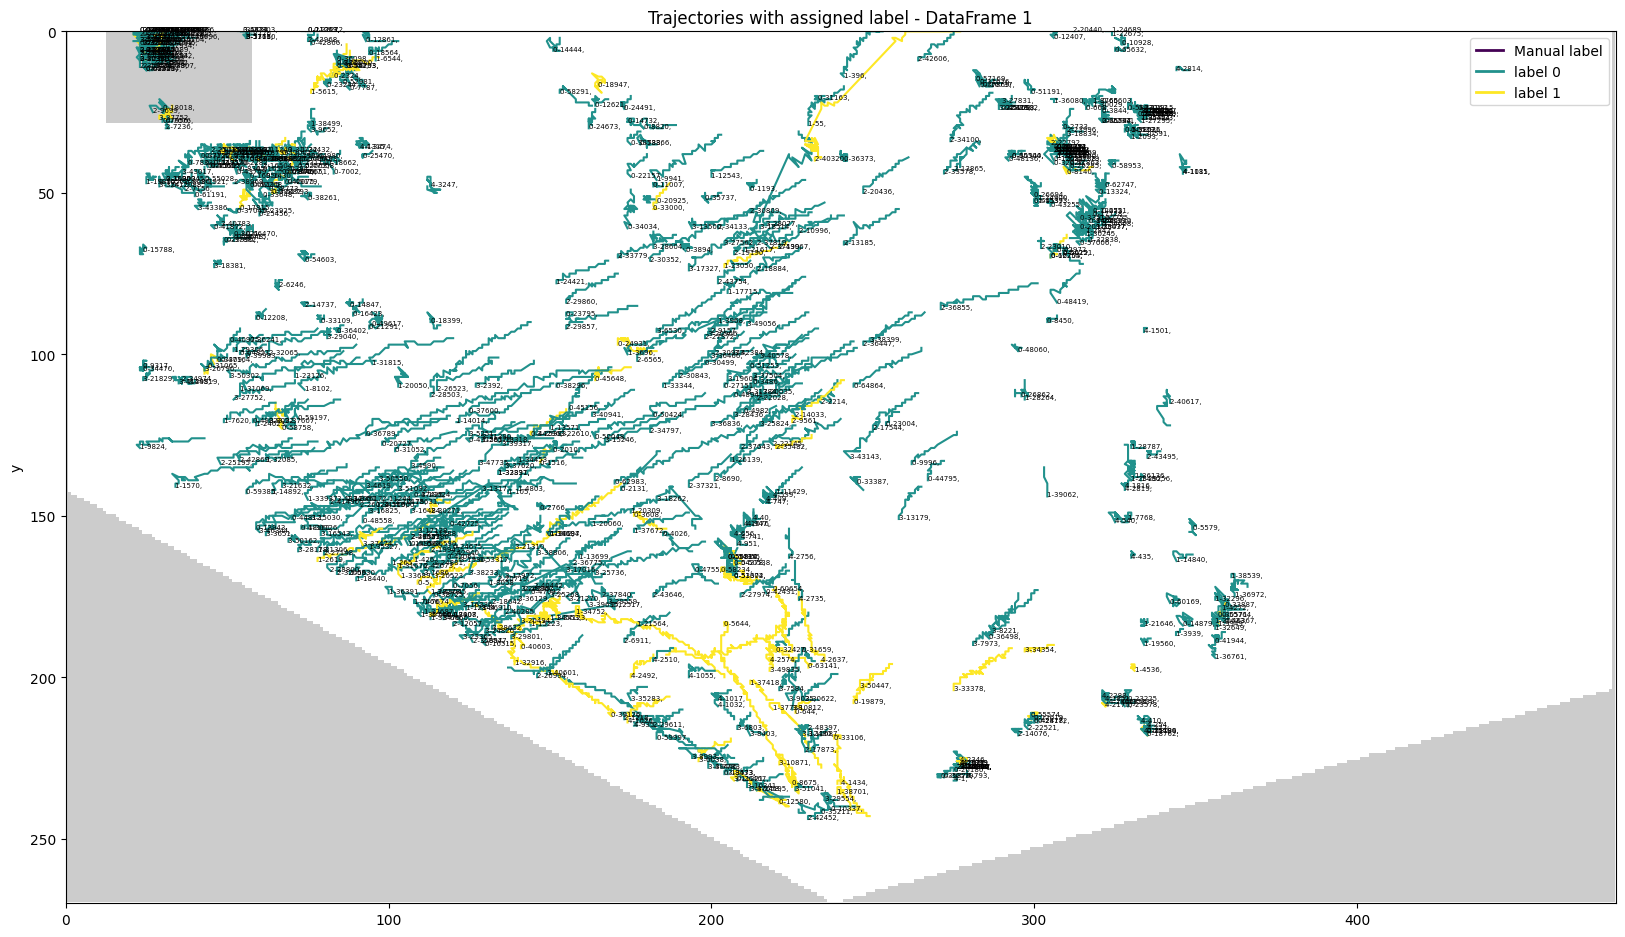

ground truth labels


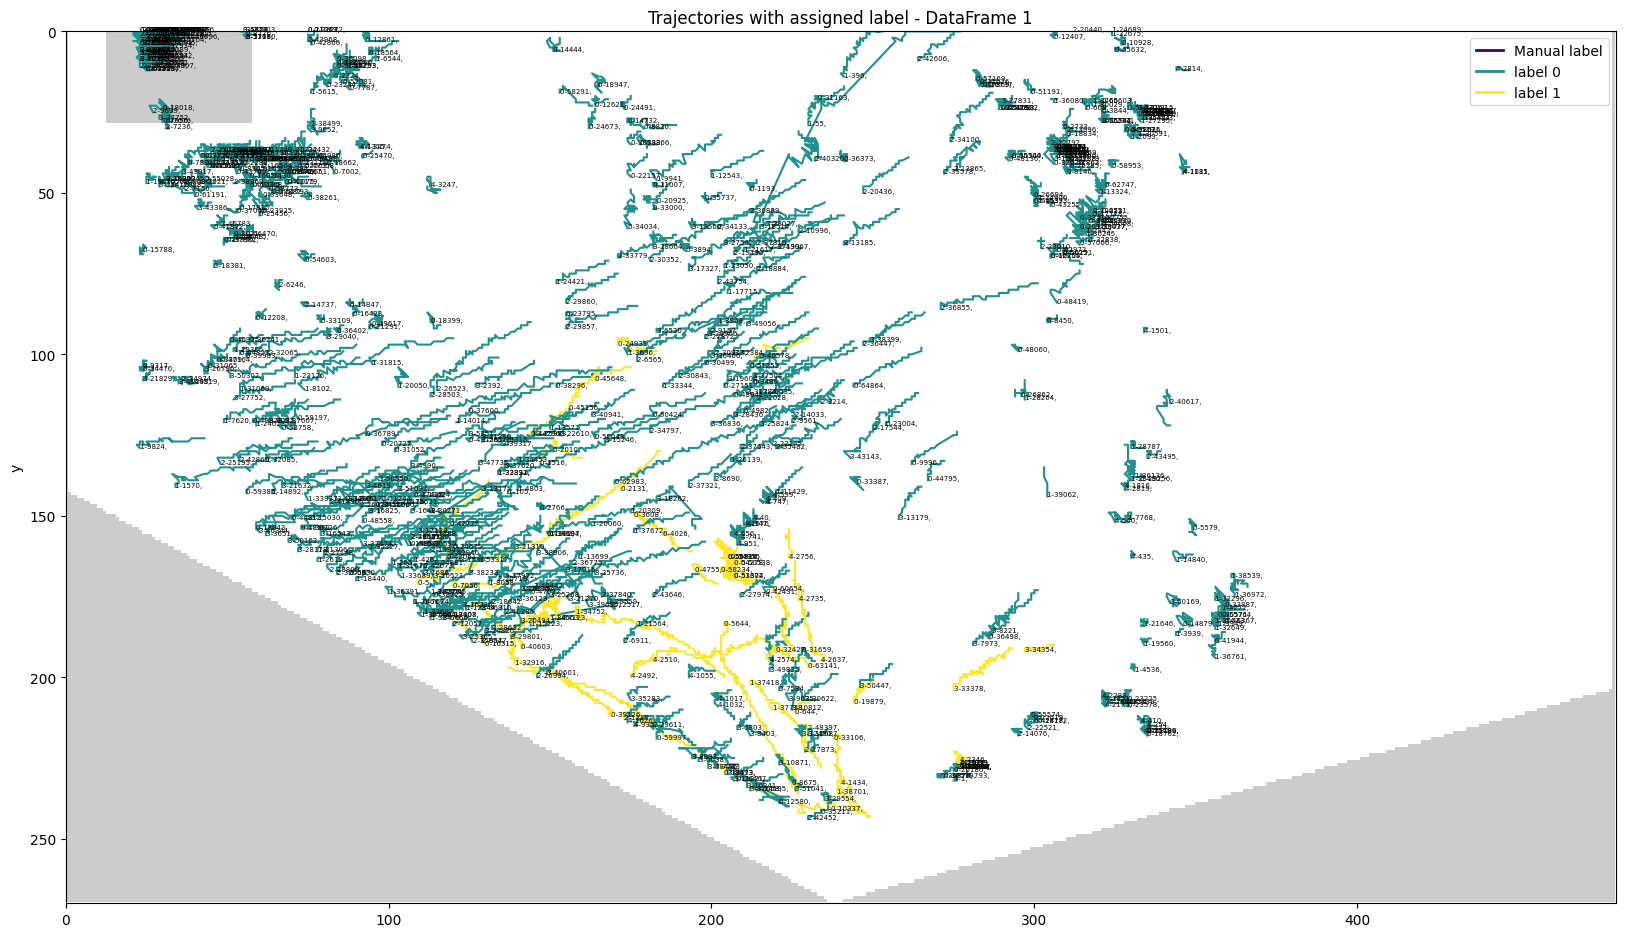

In [136]:
plotter.overwrite_classification_v2(pd.DataFrame(y_pred, columns=['xgboost'], index=feature_df.index))

plotter.plot_track_pairings(
    show_track_id=True,
    mask_to_show="flow_area_mask",
    column_with_label="xgboost",
    figsize=(20, 20),
)

print("ground truth labels")
plotter.plot_track_pairings(
    show_track_id=True,
    mask_to_show="flow_area_mask",
    column_with_label="gt_label",
    figsize=(20, 20),
)

In [65]:
dump_df = plotter.measurements_dfs[0].copy().drop(columns=['image_tile', 'binary_image'])
dump_df['classification_v2'] = dump_df['xgboost'].astype(int)
dump_df.to_csv('../../data/model_output_classified/Passe3_Mar11_12-37-58_classification_v2.csv', index=False)


In [151]:
from analysis.classification_utils.dataframe_manipulations import save_classified_trajectories

save_classified_trajectories(
    test_plotter.measurements_dfs,
    measurement_csv_paths,
    save_dir='temp/',
    name_extension=f'_classification_min_track_length_{gen.min_track_length}',
)

Saved temp/Tourelle_Mar11_07-10-01_classification_min_track_length_30.csv


# Correlation Matrix to Identify Important Features

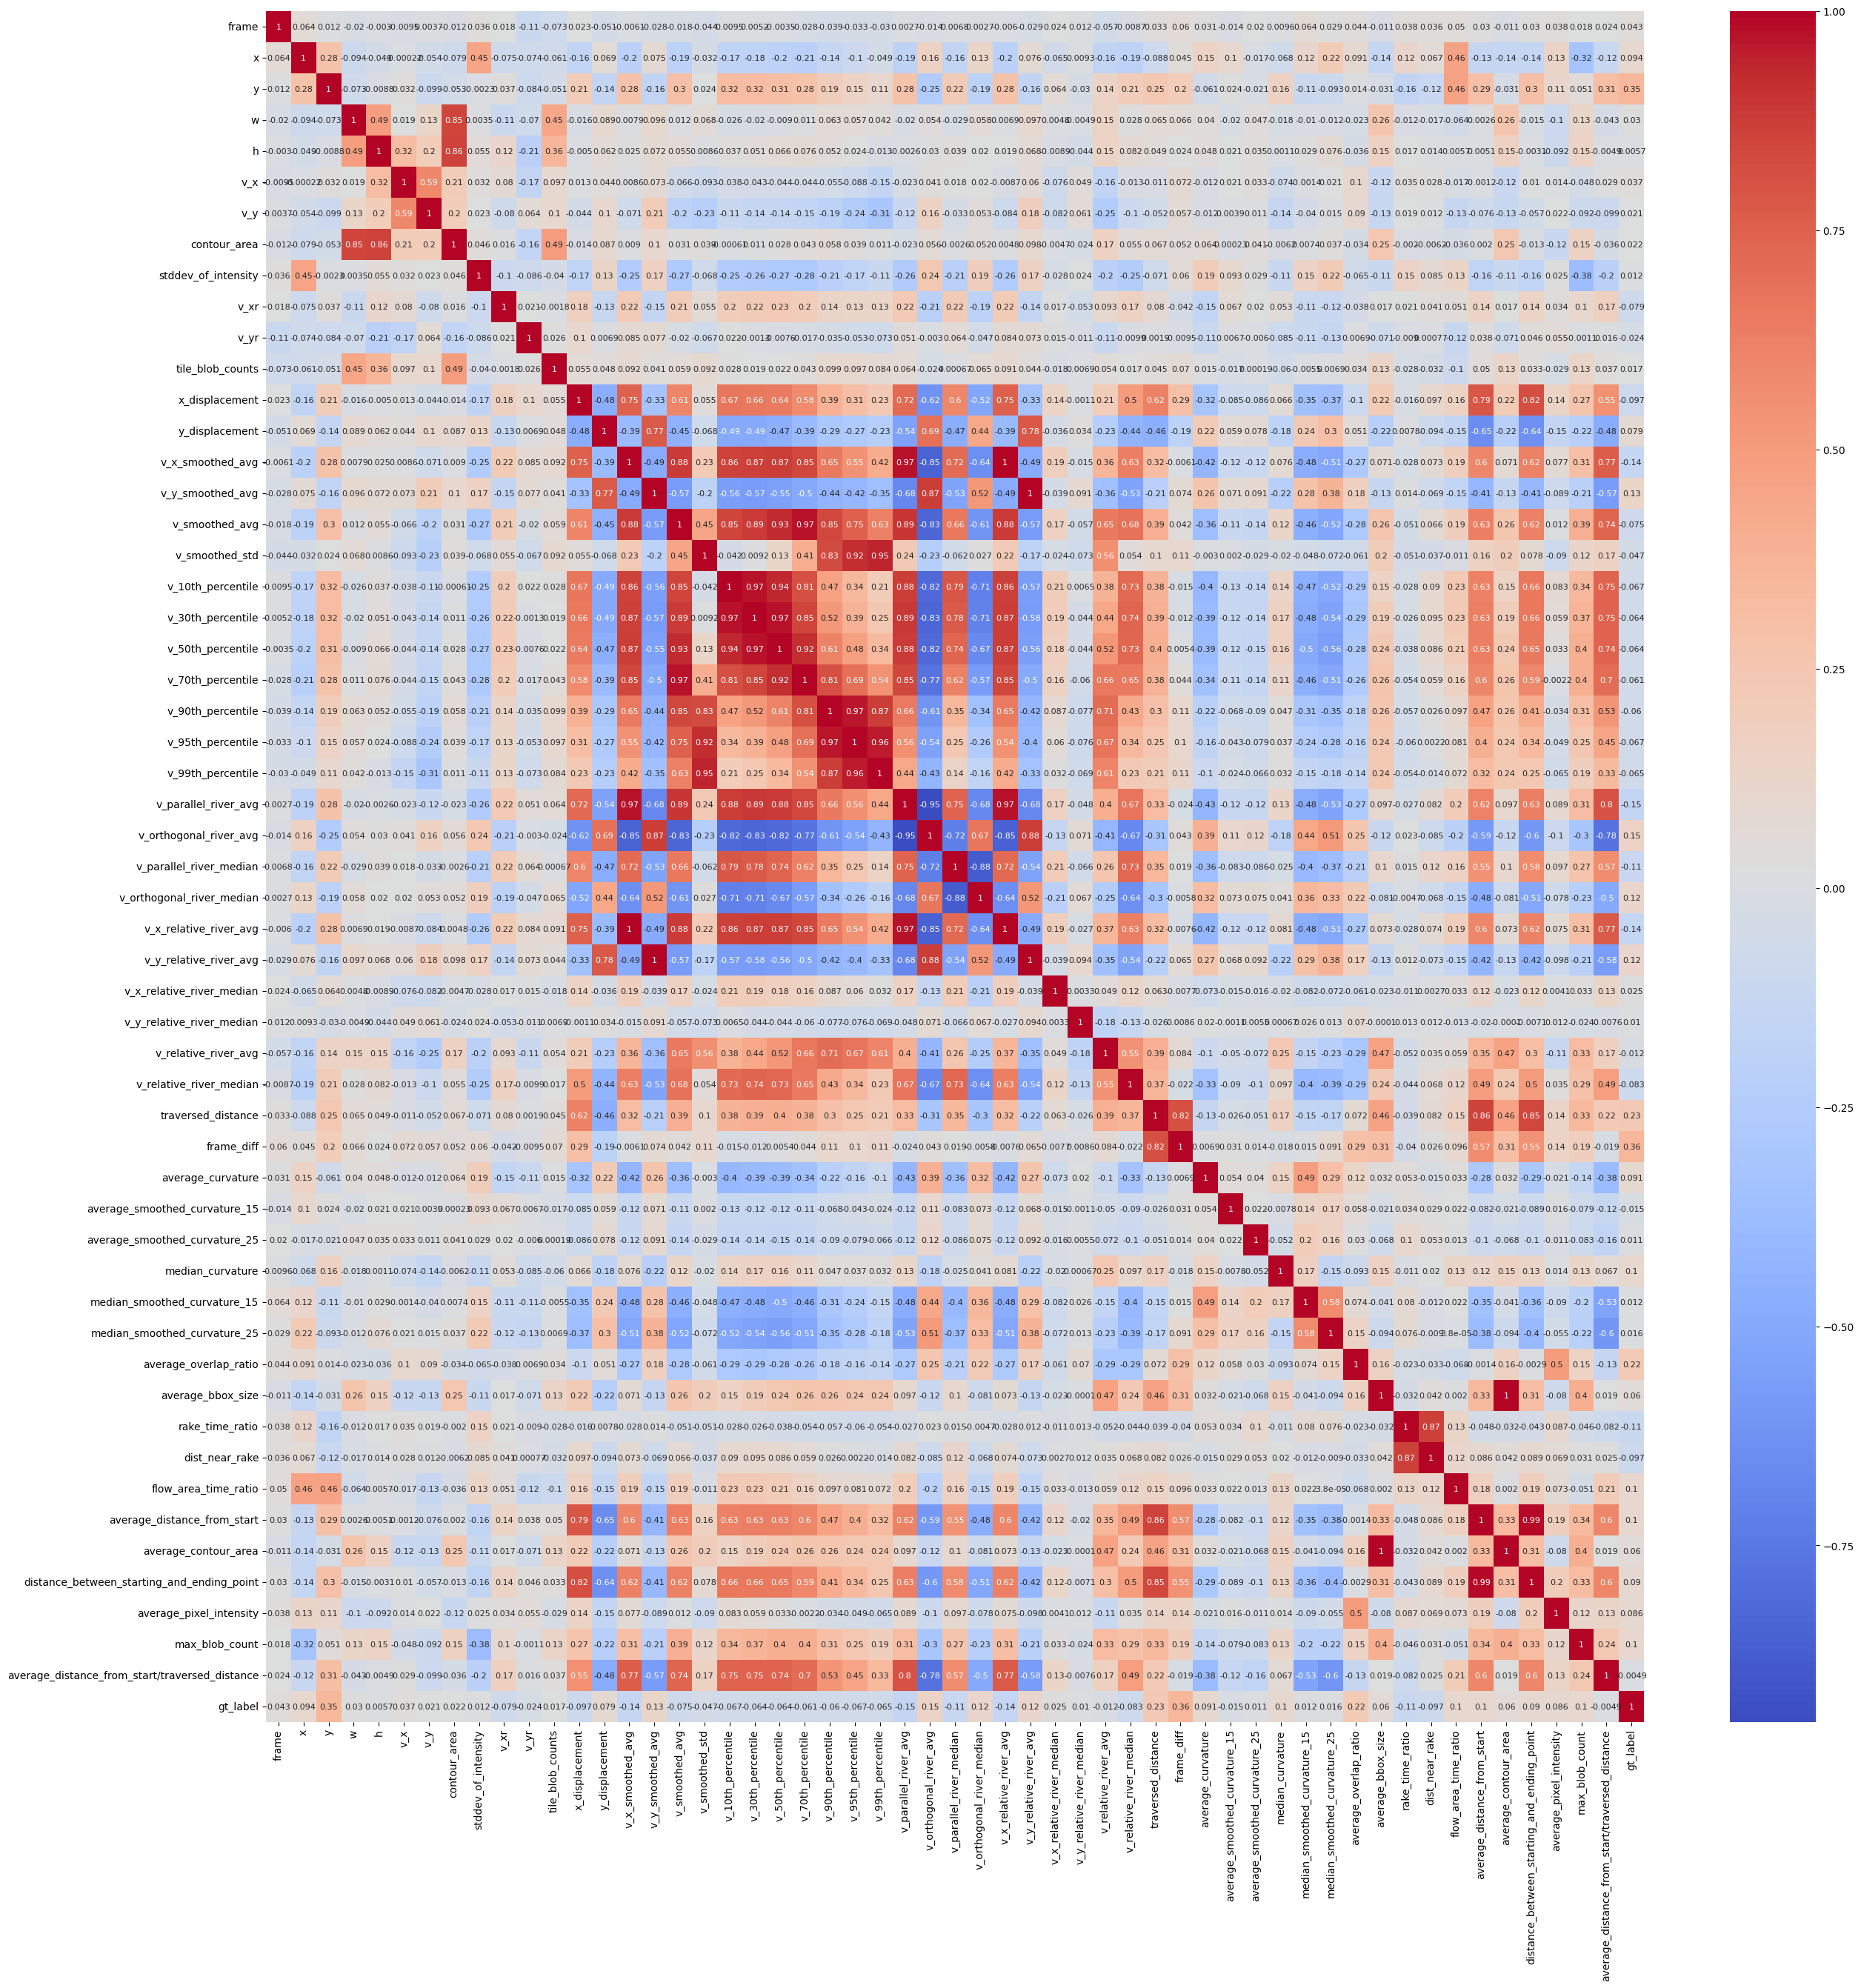

In [256]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(30, 30))

# Compute the correlation matrix
corr_matrix = feature_df.corr()

# Create a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={"fontsize":8})

# Show the plot
plt.show()

# Shorten a Video

In [ ]:
import cv2

def cut_video(input_path, start_time, end_time):
    # Read the video
    video = cv2.VideoCapture(input_path)

    # Get the frame rate of the video
    fps = video.get(cv2.CAP_PROP_FPS)

    # Convert start and end time to seconds
    start_seconds = int(start_time.split(':')[0]) * 60 + int(start_time.split(':')[1])
    end_seconds = int(end_time.split(':')[0]) * 60 + int(end_time.split(':')[1])

    # Calculate the start and end frames
    start_frame = int(start_seconds * fps)
    end_frame = int(end_seconds * fps)

    # Set the video writer
    output_path = input_path.replace('.mp4', '_short.mp4')
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output_video = cv2.VideoWriter(output_path, fourcc, fps, (int(video.get(3)), int(video.get(4))))

    # Read and write frames within the specified time frame
    frame_count = 0
    while True:
        ret, frame = video.read()
        if not ret:
            break

        if frame_count >= start_frame and frame_count <= end_frame:
            output_video.write(frame)

        frame_count += 1

        if frame_count > end_frame:
            break

    # Release the video capture and writer
    video.release()
    output_video.release()

    print(f"Video saved as {output_path}")

# Example usage
input_path = "../../data/model_output_classified/Passe3_Mar11_12-37-58_classified.mp4"
start_time = "00:45"
end_time = "01:10"

cut_video(input_path, start_time, end_time)